In [44]:
import ML_for_WDN
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import wntr
import networkx as nx
from datetime import datetime
import traces
from datetime import timedelta

# Set working directory
abs_path = '/home/ntm/PhD/ML-for-WDN/notebooks/'
os.chdir(abs_path + '..')


/tmp/ipykernel_1105547/4071321293.py:16: DeprecationWarning: wntr.network.WaterNetworkModel.get_graph is deprecated, use wntr.network.WaterNetworkModel.to_graph instead
  G = wn.get_graph()
/home/ntm/PhD/ML-for-WDN/.venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)
/home/ntm/PhD/ML-for-WDN/.venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)
/tmp/ipykernel_1105547/4071321293.py:46: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise

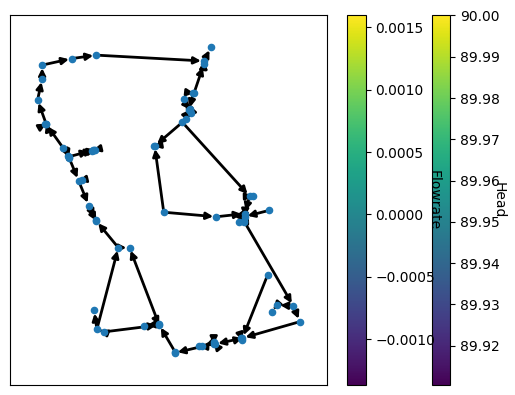

In [45]:
# Getting path for the input file
inputfiles_folder_name = 'epanet_input_files/'
filename = 'IISc_campus.inp'
inp_file = os.path.join(inputfiles_folder_name, filename)

# Reading the input file into EPANET
wn = wntr.network.WaterNetworkModel(inp_file)

sim = wntr.sim.WNTRSimulator(wn)
results = sim.run_sim()

head = results.node['head']
flow_rate = results.link['flowrate']
#head = np.asarray(head)

G = wn.get_graph()

vmin = np.min(head).min()
vmax = np.max(head).max()
edge_min = np.min(flow_rate).min()
edge_max = np.max(flow_rate).max()

node_cmap = plt.get_cmap('viridis')
edge_cmap = plt.get_cmap('viridis')

nx.draw_networkx(
    G=G, 
    pos=nx.get_node_attributes(G, 'pos'), 
    with_labels=False,
    node_size=20,
    #node_color=results.node['head'].iloc()[0],
    #cmap=node_cmap,
    #vmin=vmin,
    #vmax=vmax,
    #edge_color=results.link['flowrate'].iloc()[0],
    #edge_cmap=edge_cmap,
    #edge_vmin=edge_min,
    #edge_vmax=edge_max,
    width=2,
    arrowsize=10,
    )
sm = plt.cm.ScalarMappable(
    cmap=node_cmap,
    norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('Head', rotation=270, fontsize=10)

sm = plt.cm.ScalarMappable(
    cmap=edge_cmap,
    norm=plt.Normalize(vmin=edge_min, vmax=edge_max))
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('Flowrate', rotation=270, fontsize=10)
plt.show()


In [388]:
# Load data
df_with_leak = pd.read_csv(
    'data/raw_data/Leak_Location_1.csv', 
    skiprows=1
)
df_with_leak['datetime'] = \
    pd.to_datetime(df_with_leak['Date'] + ' ' + df_with_leak['Time'])
df_with_leak['day_of_week'] = df_with_leak['datetime'].dt.day_name()
df_with_leak['Date'] = pd.to_datetime(df_with_leak['Date'])
df_with_leak['Date'] = df_with_leak['Date'].dt.date - df_with_leak['Date'].dt.date.min()
df_with_leak['Time'] = pd.to_datetime(df_with_leak['Time'], format='%H:%M:%S').dt.time

df_without_leak = pd.read_csv(
    'data/raw_data/No_Leak_Experiment.csv',
    skiprows=1
)
df_without_leak['datetime'] = \
    pd.to_datetime(df_without_leak['Date'] + ' ' + df_without_leak['Time'])
df_without_leak['day_of_week'] = df_without_leak['datetime'].dt.day_name()
df_without_leak['Date'] = pd.to_datetime(df_without_leak['Date'])
df_without_leak['Date'] = df_without_leak['Date'].dt.date - df_without_leak['Date'].dt.date.min()
df_without_leak['Time'] = pd.to_datetime(df_without_leak['Time'], format='%H:%M:%S').dt.time

first_time = np.maximum(
    df_with_leak['Time'][0],
    df_without_leak['Time'][0]
)

df_without_leak = df_without_leak.drop(df_without_leak[(df_without_leak['Time'] < first_time) & (df_without_leak['Date'] == "0 days")].index)
df_with_leak = df_with_leak.drop(df_with_leak[(df_with_leak['Time'] < first_time) & (df_with_leak['Date'] == "0 days")].index)

last_date = np.minimum(
    df_with_leak['Date'].max(),
    df_without_leak['Date'].max()
)

df_without_leak = df_without_leak.drop(df_without_leak[df_without_leak['Date'] > last_date].index)
df_with_leak = df_with_leak.drop(df_with_leak[df_with_leak['Date'] > last_date].index)

last_time = np.minimum(
    df_with_leak['Time'].iloc()[-1],
    df_without_leak['Time'].iloc()[-1]
)

df_without_leak = df_without_leak.drop(df_without_leak[(df_without_leak['Time'] > last_time) & (df_without_leak['Date']==last_date)].index)
df_with_leak = df_with_leak.drop(df_with_leak[(df_with_leak['Time'] > last_time) & (df_with_leak['Date']==last_date)].index)


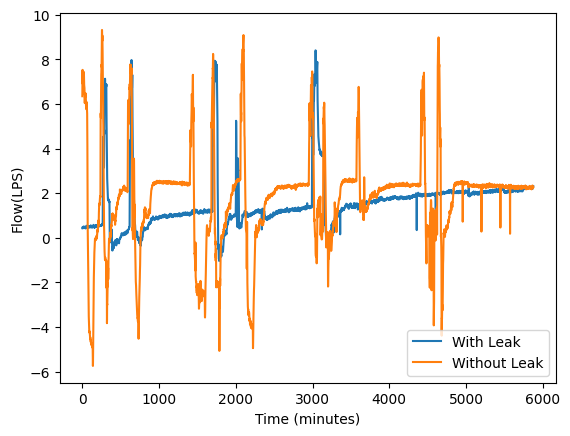

In [401]:
sensor_1 = 'FM09'

flow_or_pressure = 'Flow(LPS)'#'Pressure (bar)' #

df_with_leak_FM09 = df_with_leak.loc[df_with_leak['FM.No.'] == sensor_1] 
df_without_leak_FM09 = df_without_leak.loc[df_without_leak['FM.No.'] == sensor_1]

ts_with_leak = traces.TimeSeries([
    (df_with_leak_FM09['datetime'].iloc()[i], df_with_leak_FM09[flow_or_pressure].iloc()[i]) for i in range(len(df_with_leak_FM09))
])

ts_without_leak = traces.TimeSeries([
    (df_without_leak_FM09['datetime'].iloc()[i], df_without_leak_FM09[flow_or_pressure].iloc()[i]) for i in range(len(df_without_leak_FM09))
])


interpolated_timeseries_with_leak = ts_with_leak.sample(
    sampling_period=timedelta(minutes=1.0),
    start=df_with_leak_FM09['datetime'].iloc()[0],
    end=df_with_leak_FM09['datetime'].iloc()[-1],
    interpolate='linear',
)
interpolated_timeseries_without_leak = ts_without_leak.sample(
    sampling_period=timedelta(minutes=1.0),
    start=df_without_leak_FM09['datetime'].iloc()[0],
    end=df_without_leak_FM09['datetime'].iloc()[-1],
    interpolate='linear',
)

interpolated_df_with_leak = pd.DataFrame(
    interpolated_timeseries_with_leak, 
    columns=['datetime', flow_or_pressure]
    )
interpolated_df_without_leak = pd.DataFrame(
    interpolated_timeseries_without_leak, 
    columns=['datetime', flow_or_pressure]
    )
    
plt.figure()
plt.plot(interpolated_df_with_leak[flow_or_pressure], label='With Leak')
plt.plot(interpolated_df_without_leak[flow_or_pressure], label='Without Leak')
plt.legend()
plt.xlabel('Time (minutes)')
plt.ylabel(flow_or_pressure)
plt.show()

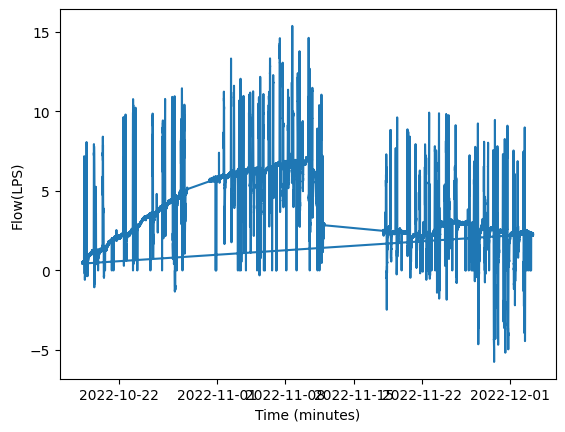

In [409]:
df_list = [
    pd.read_csv(
        f'data/raw_data/No_Leak_Experiment.csv', 
        skiprows=1
    )]
for i in range(1, 4):
    df_list.append(
        pd.read_csv(
            f'data/raw_data/Leak_Location_{i}.csv', 
            skiprows=1
        )
    )

df = pd.concat(df_list)
df['datetime'] = \
    pd.to_datetime(df['Date'] + ' ' + df['Time'])

sensor_1 = 'FM09'

flow_or_pressure = 'Flow(LPS)'#'Pressure (bar)' #

df = df.loc[df['FM.No.'] == sensor_1]

plt.figure()
plt.plot(df['datetime'], df[flow_or_pressure])
plt.xlabel('Time (minutes)')
plt.ylabel(flow_or_pressure)
plt.show()

In [408]:
df

,Unnamed: 0,Sr. No.,FM.No.,Flow(LPS),Pressure (bar),Month_Flow,EpochTime,Date,Time
8,10873,410874,FM09,2.67,3.45,2657.00,1669660270,11/29/2022,0:01:10
18,10883,410884,FM09,2.62,3.47,2657.06,1669660358,11/29/2022,0:02:38
28,10893,410894,FM09,2.66,3.49,2657.13,1669660446,11/29/2022,0:04:06
38,10903,410904,FM09,2.64,3.48,2657.19,1669660534,11/29/2022,0:05:34
48,10913,410914,FM09,2.58,3.51,2657.26,1669660622,11/29/2022,0:07:02
...,...,...,...,...,...,...,...,...,...
110494,110823,410824,FM09,2.59,3.44,2656.68,1669659830,11/28/2022,23:53:50
110504,110833,410834,FM09,2.64,3.47,2656.74,1669659918,11/28/2022,23:55:18
110514,110843,410844,FM09,2.60,3.48,2656.81,1669660006,11/28/2022,23:56:46
110524,110853,410854,FM09,2.66,3.48,2656.87,1669660094,11/28/2022,23:58:14


/tmp/ipykernel_1105547/1545441324.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_with_leak_1['datetime'] -= df_with_leak_1['datetime'].min()
/tmp/ipykernel_1105547/1545441324.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_without_leak_1['datetime'] -= df_without_leak_1['datetime'].min()
/tmp/ipykernel_1105547/1545441324.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

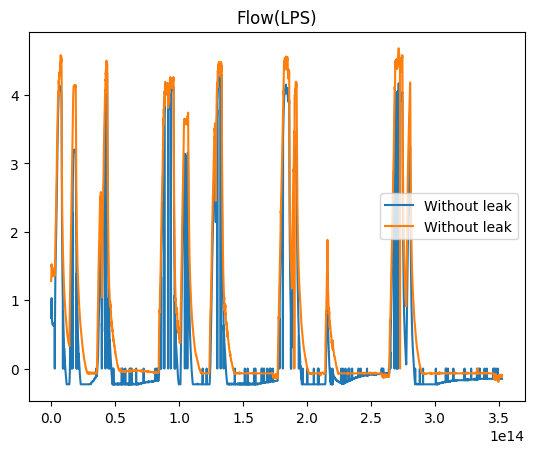

In [394]:
sensor_1 = 'FM08'
sensor_2 = 'FM01'

# Get sensor readings for sensor 1
df_with_leak_1 = df_with_leak.loc[df_with_leak['FM.No.'] == sensor_1] 
df_without_leak_1 = df_without_leak.loc[df_without_leak['FM.No.'] == sensor_1]

df_with_leak_1['datetime'] -= df_with_leak_1['datetime'].min()
df_without_leak_1['datetime'] -= df_without_leak_1['datetime'].min()

# Get sensor readings for sensor 2
df_with_leak_2 = df_with_leak.loc[df_with_leak['FM.No.'] == sensor_2] 
df_without_leak_2 = df_without_leak.loc[df_without_leak['FM.No.'] == sensor_2]

df_with_leak_2['datetime'] -= df_with_leak_2['datetime'].min()
df_without_leak_2['datetime'] -= df_without_leak_2['datetime'].min()

# Plot pressure readings for FM08
plt.figure()
'''
plt.plot(
    df_with_leak_1['datetime'], 
    df_with_leak_1['Pressure (bar)'],
    label='With leak'
    )
'''
plt.plot(
    df_without_leak_1['datetime'], 
    df_without_leak_1['Pressure (bar)'],
    label='Without leak'
    )
'''
plt.plot(
    df_with_leak_2['EpochTime'], 
    df_with_leak_2['Pressure (bar)'],
    label='With leak'
    )
'''
plt.plot(
    df_without_leak_2['datetime'], 
    df_without_leak_2['Pressure (bar)'],
    label='Without leak'
    )

plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Pressure (Pa)')
plt.title('Pressure readings for FM01')
plt.show()